# Prediction of Google Quick Draw images

In 2018 Google hosted a game called **_Quick, Draw!_** where players were given 20 seconds to draw an object based on a word prompt such as "mountain", "sun", "beard".  Google had a neural net trained to guess the image as the player was drawing it (and presumably had some ongoing reinforcement learning occurring, too). They've open sourced all (?) the sketches for people to play with.

- [Quick, Draw! main data page](https://quickdraw.withgoogle.com/data)
- [Project GitHub Repo](https://github.com/googlecreativelab/quickdraw-dataset)
- [Google cloud storage for all sketches](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap/?pli=1)

We've downloaded 6 classes of sketches. These drawings have been rendered into a 28x28 grayscale bitmap and are aligned to the center of the drawing's bounding box. We've chosen two dominant groups of sketches: wing-dominated, and cicular.  In the first group are fish, bowtie, and angel.  The second group consists of basketball, baseball, and face.

Our goal will be to predict what the sketch is trying to represent.  To do this we'll run a Restricted Boltzmann Machine to extract 10 useful features from each drawing class.  Then we'll feed those features into a fairly simplistic logistic regression and random forest.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random

from sklearn.utils import shuffle
from sklearn.neural_network import BernoulliRBM
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

%matplotlib inline

In [2]:
# Loading 10,000 image random subsets of each dataset
fish = np.load('./QuickDrawImages/fish_10k.npy')
bowtie = np.load('./QuickDrawImages/bowtie_10k.npy')
angel = np.load('./QuickDrawImages/angel_10k.npy')
basketball = np.load('./QuickDrawImages/basketball_10k.npy')
baseball = np.load('./QuickDrawImages/baseball_10k.npy')
face = np.load('./QuickDrawImages/face_10k.npy')

In [3]:
print(fish.shape)
print(bowtie.shape)
print(angel.shape)
print(basketball.shape)
print(baseball.shape)
print(face.shape)

(10000, 784)
(10000, 784)
(10000, 784)
(10000, 784)
(10000, 784)
(10000, 784)


We have 6 sets of 10,000 drawings each:
- Fish
- Bowtie
- Angel
- Basketball
- Baseball
- Face

The first three are dominantly "wing-shaped" and the second three are "ball-shaped with lines". 

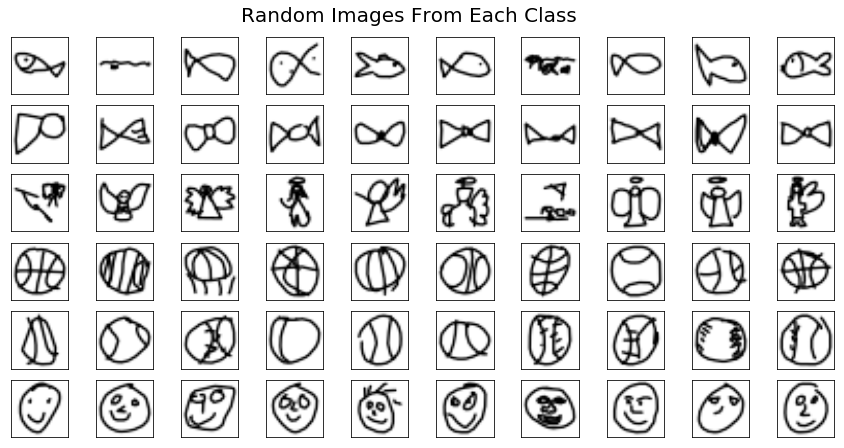

In [4]:
# Plotting random examples from each class

index = []
for i in range(10):
    index.append(random.randint(0,10000))

image_classes = [fish, bowtie, angel, basketball, baseball, face]

counter = 1

plt.figure(figsize=(15,7))
plt.suptitle('Random Images From Each Class', size=20)

for ic in image_classes:
    for idx in index:
        plt.subplot(6,10,counter)
        plt.imshow(ic[idx].reshape((28, 28)), cmap="Greys", interpolation='bilinear')
        plt.xticks(())
        plt.yticks(())
        
        counter += 1

plt.subplots_adjust(top=.92)
plt.show()

The individual images are unsigned 8-bit which means their values are scaled from (0, 255).  The SKlearn RBM implementation requires that the values be scaled from (0, 1).

In [5]:
def scale(X, eps = 0.001):
    # Scale the data points so that the values are within the range [0, 1]
    return (X - np.min(X, axis = 0)) / (np.max(X, axis = 0) + eps)

fish = scale(fish)
bowtie = scale(bowtie)
angel = scale(angel)
basketball = scale(basketball)
baseball = scale(baseball)
face = scale(face)

# Qualitative Feature Visualization

RBM's output features which can be qualitatively judged for representativeness.  Doing this visual QC ensures that we have a variety of useful features being input into the model.  After doing some manual grid searching through the hyperparameter space, I've landed on a set of hyperparameters which work well for every class and don't take too long to run.

First let's visualize these potential features.  Then, **_after_** splitting the data, we will run RBMs for each class again to ensure that we do not train on our test images.

[BernoulliRBM] Iteration 1, pseudo-likelihood = -361.64, time = 0.56s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -318.20, time = 0.54s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -283.72, time = 0.55s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -270.31, time = 0.46s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -272.08, time = 0.40s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -274.27, time = 0.41s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -260.18, time = 0.38s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -252.24, time = 0.48s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -237.16, time = 0.38s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -239.02, time = 0.36s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -239.72, time = 0.36s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -237.18, time = 0.37s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -237.84, time = 0.36s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -236.98, time = 0.35s
[BernoulliRBM] 

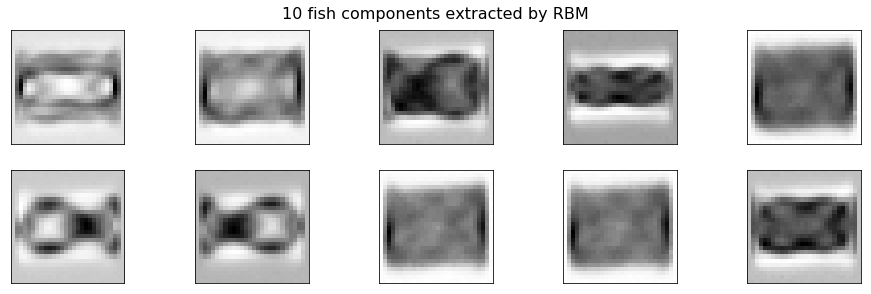

In [6]:
# RBM instantiation for the all fish images
rbm = BernoulliRBM(n_components=10, 
                   learning_rate=0.001, 
                   batch_size=10, 
                   n_iter=100, 
                   verbose=1)

# Fitting with the full dataset to visualize the resulting features
rbm.fit(fish)

# Plotting the features
plt.figure(figsize=(15, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(2, 5, i + 1)
    plt.imshow(comp.reshape((28, 28)), 
               cmap="Greys", 
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('10 fish components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.90, 0.08, 0.23)
plt.subplots_adjust()
plt.show()

Note that these features look like bowties because there was not a defined direction to draw the fish.  Apparently users drew fish facing each direction about equally.  (Editor's note: I much prefer a left-facing fish) After hyperparameter searching, there seems to be no additional useful features to extract.

[BernoulliRBM] Iteration 1, pseudo-likelihood = -352.62, time = 0.35s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -316.64, time = 0.37s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -291.17, time = 0.40s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -280.68, time = 0.37s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -269.73, time = 0.36s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -252.04, time = 0.36s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -248.01, time = 0.35s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -240.71, time = 0.35s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -244.32, time = 0.35s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -231.70, time = 0.35s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -231.02, time = 0.36s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -234.74, time = 0.34s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -231.24, time = 0.34s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -228.22, time = 0.35s
[BernoulliRBM] 

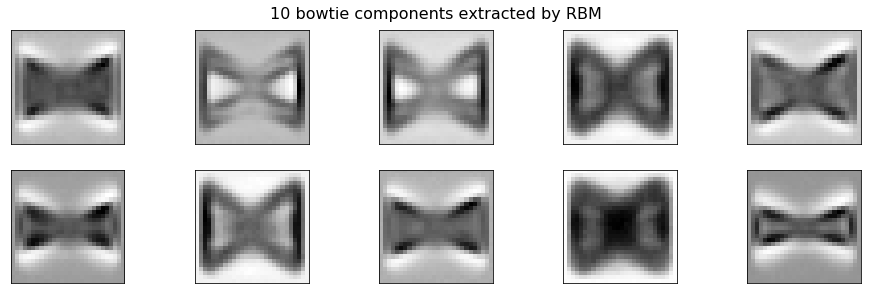

In [7]:
# RBM instantiation for all bowtie images
rbm = BernoulliRBM(n_components=10, 
                   learning_rate=0.001, 
                   batch_size=10, 
                   n_iter=100, 
                   verbose=1)

# Fitting with the full dataset to visualize the resulting features
rbm.fit(bowtie)

# Plotting the features
plt.figure(figsize=(15, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(2, 5, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap="Greys",
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('10 bowtie components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.90, 0.08, 0.23)
plt.subplots_adjust()
plt.show()

[BernoulliRBM] Iteration 1, pseudo-likelihood = -384.11, time = 0.35s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -362.55, time = 0.38s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -344.15, time = 0.37s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -316.28, time = 0.36s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -315.17, time = 0.36s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -309.68, time = 0.36s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -312.07, time = 0.37s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -310.53, time = 0.36s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -312.66, time = 0.36s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -304.33, time = 0.35s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -304.46, time = 0.36s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -308.46, time = 0.36s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -299.57, time = 0.36s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -295.66, time = 0.36s
[BernoulliRBM] 

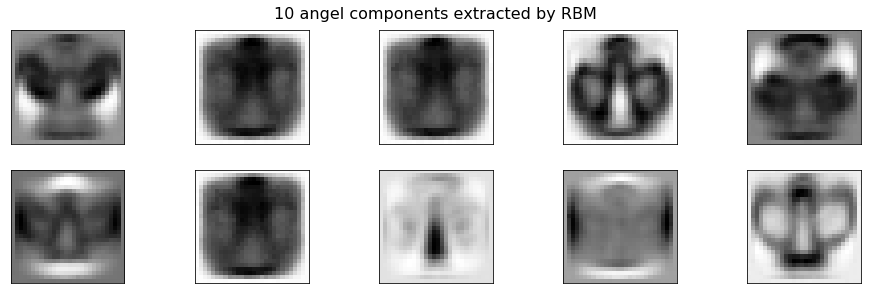

In [8]:
# RBM instantiation for all angel images
rbm = BernoulliRBM(n_components=10, 
                   learning_rate=0.001, 
                   batch_size=10, 
                   n_iter=100, 
                   verbose=1)

# Fitting with the full dataset to visualize the resulting features
rbm.fit(angel)

# Plotting the features
plt.figure(figsize=(15, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(2, 5, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap="Greys",
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('10 angel components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.90, 0.08, 0.23)
plt.subplots_adjust()
plt.show()

[BernoulliRBM] Iteration 1, pseudo-likelihood = -412.67, time = 0.36s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -381.58, time = 0.39s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -369.28, time = 0.39s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -361.56, time = 0.36s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -358.68, time = 0.36s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -352.50, time = 0.36s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -357.62, time = 0.37s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -346.35, time = 0.36s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -343.84, time = 0.36s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -347.02, time = 0.35s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -346.11, time = 0.35s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -341.34, time = 0.37s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -344.11, time = 0.35s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -338.18, time = 0.35s
[BernoulliRBM] 

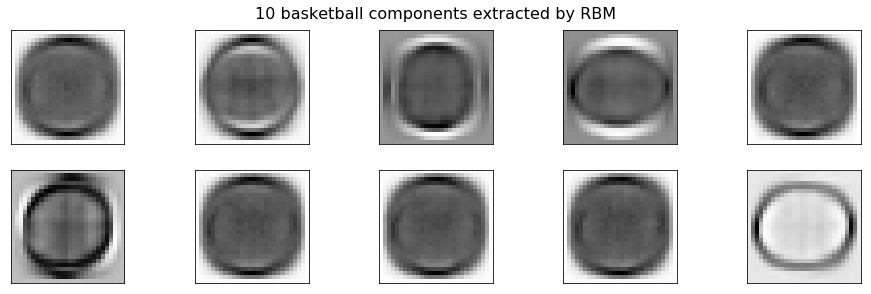

In [9]:
# RBM instantiation for all basketball images
rbm = BernoulliRBM(n_components=10, 
                   learning_rate=0.001, 
                   batch_size=10, 
                   n_iter=100, 
                   verbose=1)

# Fitting with the full dataset to visualize the resulting features
rbm.fit(basketball)

# Plotting the features
plt.figure(figsize=(15, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(2, 5, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap="Greys",
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('10 basketball components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.90, 0.08, 0.23)
plt.subplots_adjust()
plt.show()

[BernoulliRBM] Iteration 1, pseudo-likelihood = -405.46, time = 0.36s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -372.56, time = 0.38s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -368.32, time = 0.37s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -330.96, time = 0.37s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -342.00, time = 0.36s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -335.52, time = 0.38s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -326.96, time = 0.38s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -317.55, time = 0.38s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -315.11, time = 0.36s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -313.58, time = 0.35s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -319.27, time = 0.38s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -313.58, time = 0.35s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -315.24, time = 0.35s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -319.96, time = 0.35s
[BernoulliRBM] 

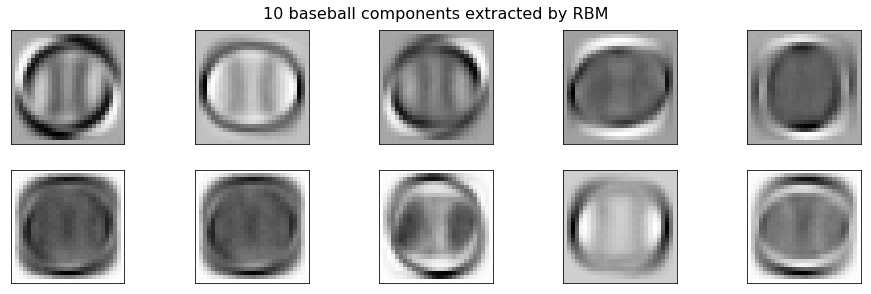

In [10]:
# RBM instantiation for all baseball images
rbm = BernoulliRBM(n_components=10, 
                   learning_rate=0.001, 
                   batch_size=10, 
                   n_iter=100, 
                   verbose=1)

# Fitting with the full dataset to visualize the resulting features
rbm.fit(baseball)

# Plotting the features
plt.figure(figsize=(15, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(2, 5, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap="Greys",
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('10 baseball components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.90, 0.08, 0.23)
plt.subplots_adjust()
plt.show()

[BernoulliRBM] Iteration 1, pseudo-likelihood = -422.66, time = 0.36s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -392.38, time = 0.38s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -351.69, time = 0.37s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -347.81, time = 0.36s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -343.62, time = 0.36s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -338.84, time = 0.40s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -331.68, time = 0.36s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -332.02, time = 0.35s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -324.84, time = 0.35s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -318.98, time = 0.36s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -320.34, time = 0.35s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -315.67, time = 0.35s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -320.85, time = 0.35s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -319.64, time = 0.35s
[BernoulliRBM] 

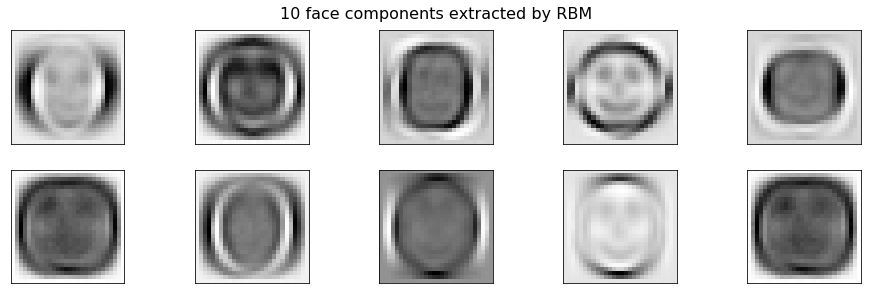

In [11]:
# RBM instantiation for all face images
rbm = BernoulliRBM(n_components=10, 
                   learning_rate=0.001, 
                   batch_size=10, 
                   n_iter=100, 
                   verbose=1)

# Fitting with the full dataset to visualize the resulting features
rbm.fit(face)

# Plotting the features
plt.figure(figsize=(15, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(2, 5, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap="Greys",
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('10 face components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.90, 0.08, 0.23)
plt.subplots_adjust()
plt.show()

# Train-Test Split

We will need to split this data manually, train an individual RBM model for training set of each class, and then combine all the train and test classes together.

The data provided by Google was presumably distributed in a random fashion, however, before I cut the 10,000 sample subsets out, I shuffled the data.  So it is demonstrably random in its current state.  Therefore, I will use simple indexing to break out the train-test splits for each class. 

Images will be encoded as below:

**Image Class**
- Fish = 0
- Bowtie = 1
- Angel = 2
- Basketball = 3
- Baseball = 4
- Face = 5

In [12]:
def rbm_train_test_split(imclass, label):
    '''
    Function to split the class up 75%-25%, assign the proper class label, 
    and run the RBM on the x_train data.
    Returns the four usual train test split outputs.
    '''
    x_train = imclass[:7500]
    x_test = imclass[7500:]
    
    y_train = [label for i in range(7500)]
    y_test = [label for i in range(2500)]
    
    rbm = BernoulliRBM(n_components=10, 
                         learning_rate=0.001, 
                         batch_size=10, 
                         n_iter=100)
    
    # Fitting the model to the training subset
    x_rbm_train = rbm.fit_transform(x_train)
    
    # Transforming the test subset to contain the same number of features
    x_rbm_test = rbm.transform(x_test)
    
    return x_rbm_train, x_rbm_test, y_train, y_test

In [13]:
# Train test splits for each class

X_fish_train, X_fish_test, Y_fish_train, Y_fish_test = rbm_train_test_split(fish, 0)

X_bowtie_train, X_bowtie_test, Y_bowtie_train, Y_bowtie_test = rbm_train_test_split(bowtie, 1)

X_angel_train, X_angel_test, Y_angel_train, Y_angel_test = rbm_train_test_split(angel, 2)

X_basketball_train, X_basketball_test, Y_basketball_train, Y_basketball_test = rbm_train_test_split(basketball, 3)

X_baseball_train, X_baseball_test, Y_baseball_train, Y_baseball_test = rbm_train_test_split(baseball, 4)

X_face_train, X_face_test, Y_face_train, Y_face_test = rbm_train_test_split(face, 5)

In [14]:
# Combining the individual train test splits

X_train = np.concatenate((X_fish_train, 
                          X_bowtie_train, 
                          X_angel_train, 
                          X_basketball_train, 
                          X_baseball_train, 
                          X_face_train), 
                         axis=0)

X_test = np.concatenate((X_fish_test, 
                          X_bowtie_test, 
                          X_angel_test, 
                          X_basketball_test, 
                          X_baseball_test, 
                          X_face_test), 
                         axis=0)

Y_train = np.concatenate((Y_fish_train, 
                          Y_bowtie_train, 
                          Y_angel_train, 
                          Y_basketball_train, 
                          Y_baseball_train, 
                          Y_face_train), 
                         axis=0)

Y_test = np.concatenate((Y_fish_test, 
                          Y_bowtie_test, 
                          Y_angel_test, 
                          Y_basketball_test, 
                          Y_baseball_test, 
                          Y_face_test), 
                         axis=0)

In [15]:
# Shuffling the samples so the order they're in does not matter
X_train, Y_train = shuffle(X_train, Y_train)
X_test, Y_test = shuffle(X_test, Y_test)

# Classification Model

In [16]:
# Grid searched multinomial logistic regression
ridge = LogisticRegression(solver='lbfgs', 
                           multi_class='multinomial', 
                           penalty='l2', 
                           max_iter=10000, 
                           C=100, 
                           n_jobs=3)

ridge.fit(X_train, Y_train)

Y_pred = ridge.predict(X_test)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      2500
           1       0.87      0.77      0.82      2500
           2       0.86      0.98      0.91      2500
           3       0.81      1.00      0.89      2500
           4       0.89      0.82      0.85      2500
           5       0.99      0.84      0.91      2500

   micro avg       0.89      0.89      0.89     15000
   macro avg       0.90      0.89      0.89     15000
weighted avg       0.90      0.89      0.89     15000



That's a pretty great model with an F1 score of 0.92.  But logistic regressions are pretty simple.  Perhaps we can get some extra performance from a tree-based model?

In [17]:
# Random Forest model
rf = RandomForestClassifier(n_estimators=25, max_depth=10, n_jobs=-1)
rf.fit(X_train, Y_train)

Y_rf_pred = rf.predict(X_test)

print(classification_report(Y_test, Y_rf_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2500
           1       1.00      1.00      1.00      2500
           2       1.00      1.00      1.00      2500
           3       1.00      1.00      1.00      2500
           4       1.00      1.00      1.00      2500
           5       1.00      1.00      1.00      2500

   micro avg       1.00      1.00      1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



Whoa.  A perfect model?!  And its a small, reasonably sized tree, too.  That's pretty awesome!